In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import warnings
import random

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import torchvision as tv

from tqdm.autonotebook import tqdm
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
plt.style.use('dark_background')
warnings.filterwarnings('ignore', 'FutureWarnings')

/kaggle/input/images-mnist/1 for mnist.png
/kaggle/input/images-mnist/7 for mnist.png
/kaggle/input/images-mnist/5 for mnist.png


## Загрузка данных

In [2]:
transform = tv.transforms.Compose(
    [
        tv.transforms.ToTensor(),
    ]
)

In [3]:
ds_mnist = tv.datasets.MNIST('/.datasets', download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 101879528.74it/s]


Extracting /.datasets/MNIST/raw/train-images-idx3-ubyte.gz to /.datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 50138946.12it/s]


Extracting /.datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /.datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27516626.80it/s]

Extracting /.datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /.datasets/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 6614766.93it/s]


Extracting /.datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /.datasets/MNIST/raw



In [4]:
X = ds_mnist.data.to(torch.float32)
y = ds_mnist.targets.to(torch.int64)

In [5]:
ds_mnist.targets.shape

torch.Size([60000])

In [6]:
ds_mnist[0][0].shape

torch.Size([1, 28, 28])

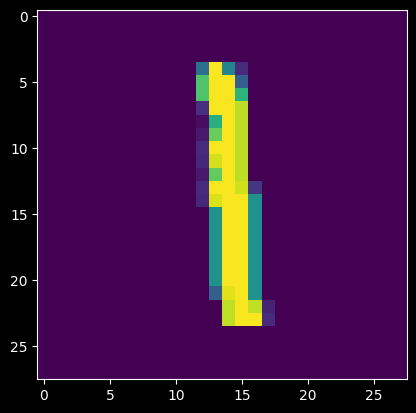

In [7]:
plt.imshow(ds_mnist[52120][0].numpy()[0])

In [8]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
## Нормализация входных данных
X = X.to(DEVICE) / 255
y = y.to(DEVICE)

## Подготовка данных

### Разбивка данных на тренировочную и тестовую выборку

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.33, random_state=77)

In [11]:
X_train.shape, X_val.shape

(torch.Size([40200, 28, 28]), torch.Size([19800, 28, 28]))

### Создание тренировочного и валидационного датасетов

In [12]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

### Создание загрузчиков

In [13]:
## Количество батчей
BATCH = 32

In [14]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH, drop_last=True)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=BATCH, drop_last=True)

In [15]:
next(iter(train_loader))[0].shape # (Количество батчей, количество каналов, ширина, высота)

torch.Size([32, 28, 28])

## Создание модели

In [16]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.lin_linear1 = nn.Linear(28*28, 300)
        self.lin_linear2 = nn.Linear(300, 10)
        
        self.dropout1 = nn.Dropout(0.2)

        self.relu = nn.ReLU()
        
        
    def forward(self, x):
        x = self.flatten(x)
        
        x = self.lin_linear1(x)
        x = self.relu(x)
        
        x = self.dropout1(x)
        x = self.lin_linear2(x)
    
        
        return x

In [17]:
model = MnistModel()

## Обучение модели

In [18]:
EPOCHS = 10
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# accuracy = Accuracy(task='multiclass', num_classes=10).to(DEVICE)

In [19]:
loss_train = []
total_loss = []

loss_val = []
total_val_loss = []

acc_val = []
rec_val = []

### Метрика accuracy

In [20]:
def accuracy(pred, target):
    proba = F.softmax(pred)
    true_list = (torch.argmax(proba, dim=1) == torch.argmax(target, dim=1)).sum()
    total_examples = len(pred)
    acc = true_list / total_examples
    return acc.detach().cpu().numpy().item()

### Процесс обучения

In [21]:
model = model.to(DEVICE)
size = len(train_loader.dataset)

for epoch in tqdm(range(EPOCHS)):
    print(f'Epochs {epoch + 1}\n ----------------------')
    for iteration, (X_batch, y_batch) in enumerate(train_loader):
        model.train()

        y_batch = F.one_hot(y_batch, num_classes=10).to(torch.float32)
        
        
        optimizer.zero_grad()
        
        outputs = model(X_batch)
        
        loss = loss_function(outputs, y_batch)
        
        loss.backward()
        
        loss_train.append(loss.detach().cpu().numpy().item())
        
        optimizer.step()
        current = (iteration + 1) * len(X_batch)
        if current % 1000 == 0:
            print(f'loss: {loss:>7f} [{current}|{size:>2d}]')
        
    total_loss.append(np.mean(loss_train))
    
    for iteration, (X_val, y_val) in enumerate(val_loader):
        model.eval()
        
        y_val = F.one_hot(y_val, num_classes=10).to(torch.float32)
        
        with torch.no_grad():
            pred = model(X_val)
            
            loss = loss_function(pred, y_val)
            
            loss_val.append(loss.detach().cpu().numpy().item())
            
            proba = F.softmax(pred)
            
            acc = accuracy(proba, y_val)
            
            acc_val.append(acc)
    
    total_val_loss.append(np.mean(loss_val))
    print(f'Validation Error: \n Accuracy: {np.mean(acc_val)} Avg Loss: {np.mean(loss_val)}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epochs 1
 ----------------------
loss: 0.599161 [4000|40200]
loss: 0.260153 [8000|40200]
loss: 0.367528 [12000|40200]
loss: 0.167969 [16000|40200]
loss: 0.398778 [20000|40200]
loss: 0.229218 [24000|40200]
loss: 0.134305 [28000|40200]
loss: 0.221996 [32000|40200]
loss: 0.045317 [36000|40200]
loss: 0.239384 [40000|40200]


/tmp/ipykernel_26/2544929619.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  proba = F.softmax(pred)
/tmp/ipykernel_26/4156142797.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  proba = F.softmax(pred)


Validation Error: 
 Accuracy: 0.9480177993527508 Avg Loss: 0.1750261493081462
Epochs 2
 ----------------------
loss: 0.097092 [4000|40200]
loss: 0.029749 [8000|40200]
loss: 0.045273 [12000|40200]
loss: 0.160821 [16000|40200]
loss: 0.078845 [20000|40200]
loss: 0.168837 [24000|40200]
loss: 0.125530 [28000|40200]
loss: 0.078022 [32000|40200]
loss: 0.227260 [36000|40200]
loss: 0.063060 [40000|40200]
Validation Error: 
 Accuracy: 0.9561589805825242 Avg Loss: 0.14732102651004364
Epochs 3
 ----------------------
loss: 0.188883 [4000|40200]
loss: 0.027986 [8000|40200]
loss: 0.066322 [12000|40200]
loss: 0.056283 [16000|40200]
loss: 0.047050 [20000|40200]
loss: 0.146037 [24000|40200]
loss: 0.070999 [28000|40200]
loss: 0.020577 [32000|40200]
loss: 0.309866 [36000|40200]
loss: 0.006898 [40000|40200]
Validation Error: 
 Accuracy: 0.9601031553398058 Avg Loss: 0.13324656011555555
Epochs 4
 ----------------------
loss: 0.025887 [4000|40200]
loss: 0.032062 [8000|40200]
loss: 0.024154 [12000|40200]
loss

### График потерь

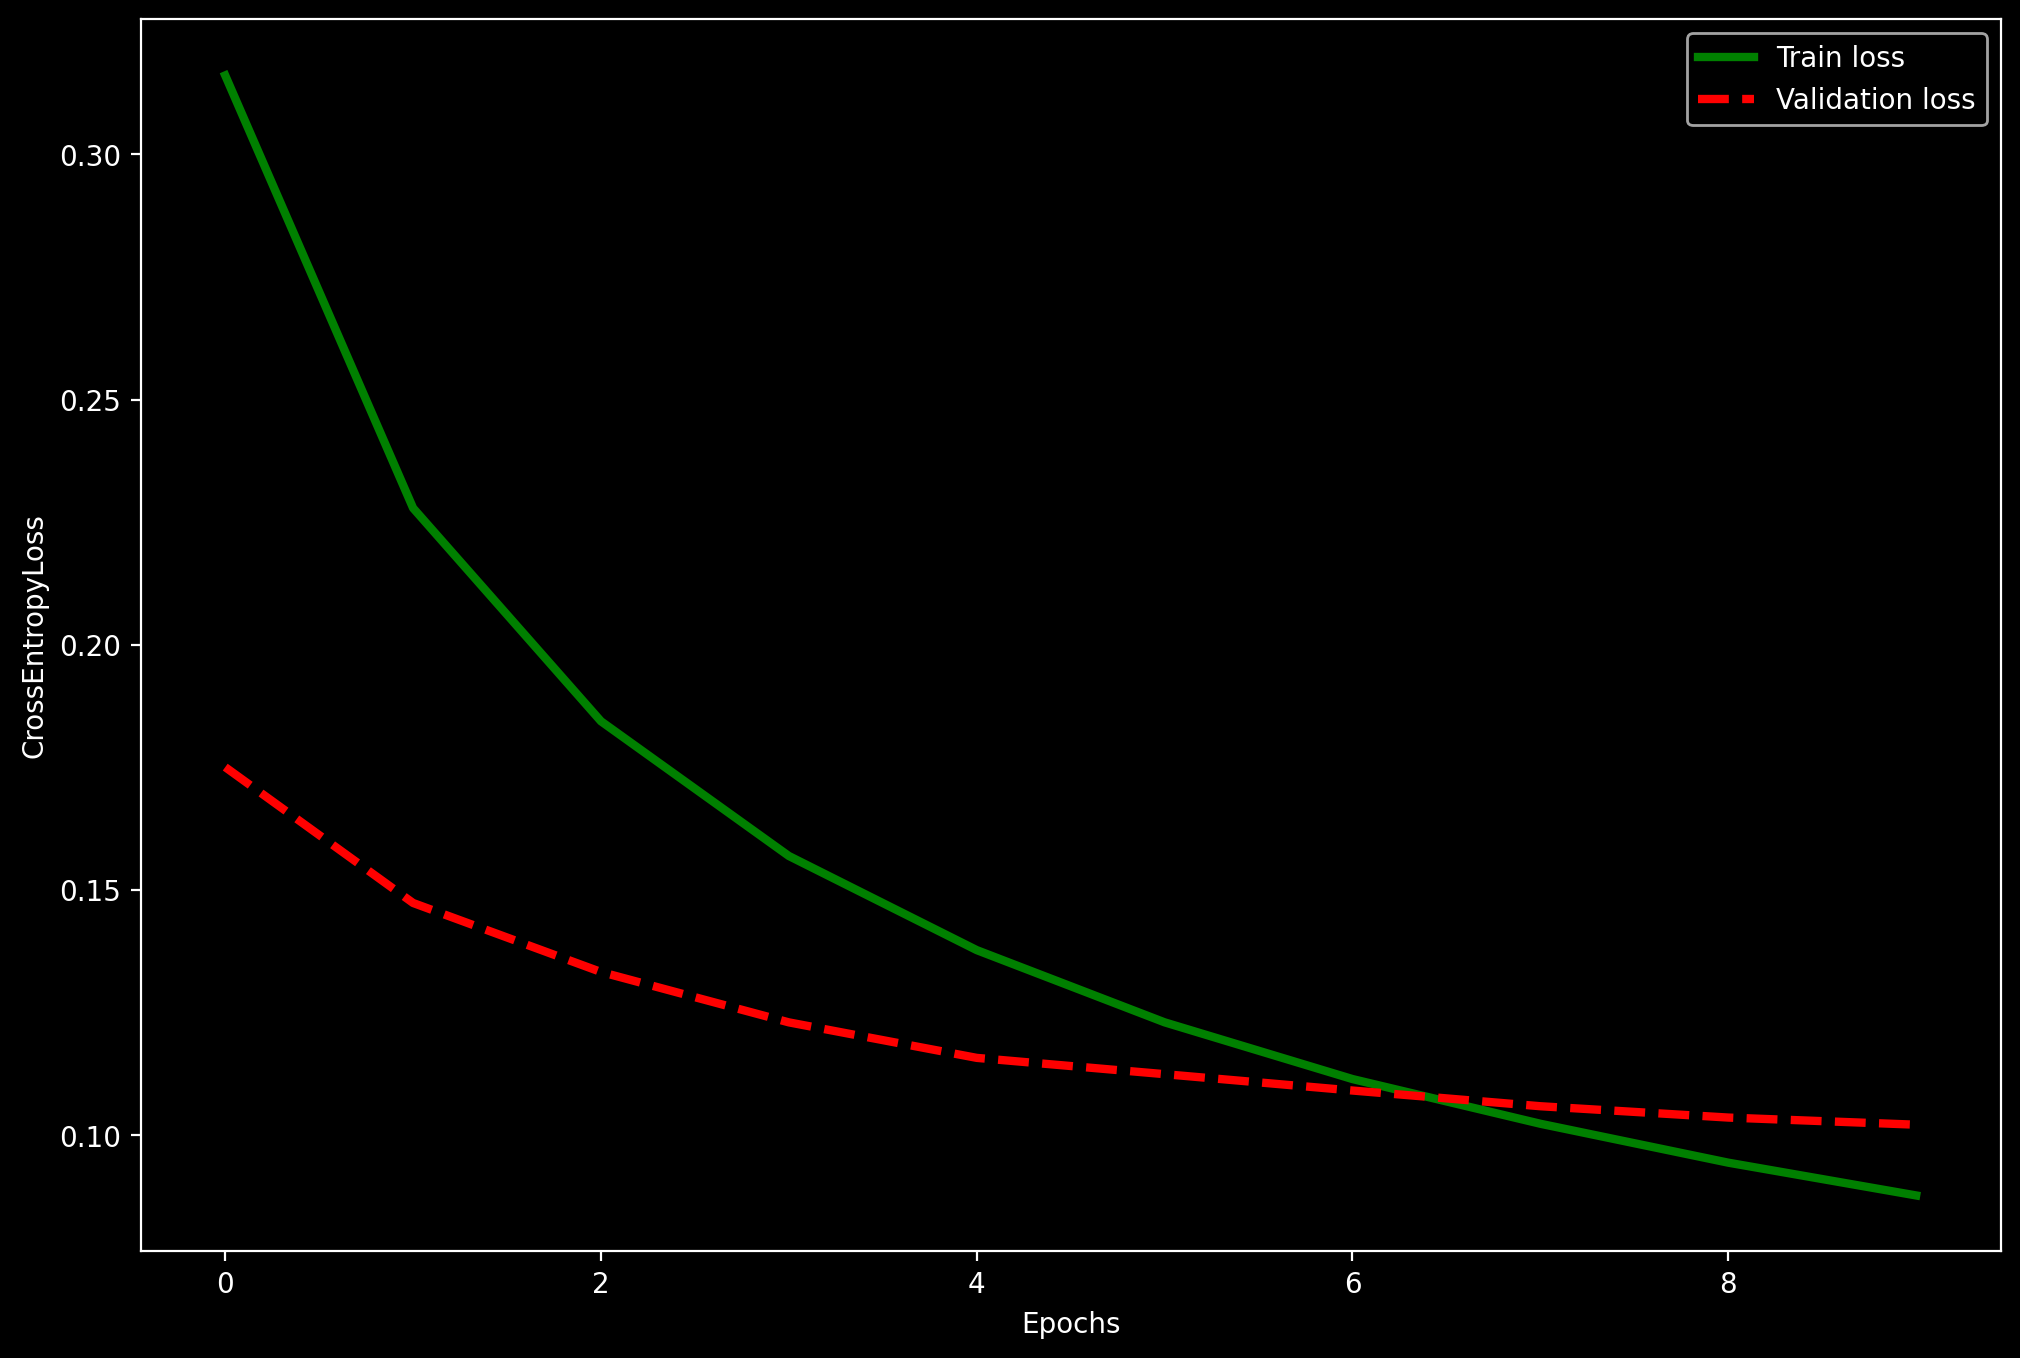

In [22]:
plt.figure(figsize=(12, 8), dpi=200)
plt.plot(total_loss, color='green', label='Train loss', linewidth=3)
plt.plot(total_val_loss, color='red', label='Validation loss', linestyle='--', linewidth=3)
plt.xlabel('Epochs')
plt.ylabel('CrossEntropyLoss')
plt.legend();

In [23]:
print(f'Accuracy: {np.mean(acc_val):.2%}')

Accuracy: 97.01%


## Рандомное число

In [24]:
indx = random.randint(0, X.shape[0])
img = X[indx]
target = y[indx]

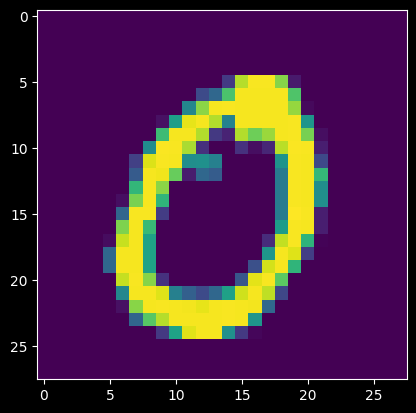

In [25]:
plt.imshow(img.cpu().numpy())

In [26]:
img = img.expand([1, 28, 28])
img.shape

torch.Size([1, 28, 28])

In [27]:
pred = model(img)
pred = torch.argmax(pred, 1).detach().cpu().numpy().item()
print(f'Предсказанное: {pred} \nИстина: {target.detach().cpu().numpy().item()}')

Предсказанное: 0 
Истина: 0
